# Forex Currencies Rates: GBP/USD – Recursive SARIMA

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Analysis-and-Transformation" data-toc-modified-id="Analysis-and-Transformation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis and Transformation</a></span><ul class="toc-item"><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Downsampling</a></span></li></ul></li><li><span><a href="#Hyper-Parameters-Search" data-toc-modified-id="Hyper-Parameters-Search-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hyper Parameters Search</a></span></li><li><span><a href="#Training-and-Validation" data-toc-modified-id="Training-and-Validation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training and Validation</a></span><ul class="toc-item"><li><span><a href="#Distributions-of-Validation-Errors" data-toc-modified-id="Distributions-of-Validation-Errors-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Distributions of Validation Errors</a></span></li><li><span><a href="#Visualization-of-Validation-Predictions" data-toc-modified-id="Visualization-of-Validation-Predictions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visualization of Validation Predictions</a></span></li></ul></li><li><span><a href="#Test-Predictions" data-toc-modified-id="Test-Predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Test Predictions</a></span></li></ul></div>

## Initialization

In [1]:
# !pip install --use-feature=in-tree-build psutil requests pmdarima nb_black

In [2]:
# !pip install --use-feature=in-tree-build ../pytorch-fit/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/pytorch-fit

In [3]:
# !pip install --use-feature=in-tree-build ../timeseries/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/timeseries

In [4]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%aimport timeseries

<IPython.core.display.Javascript object>

In [5]:
import os
import IPython.display
from pprint import pprint
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf

import timeseries as tss
from timeseries.plotting import plot_ts, plot_hist, plot_acf, plot_pacf
from timeseries.transform import (
    IHSTransformer,
    get_smoothed,
    get_downsampled,
    get_interpolated,
)

from utils.timeseries_data import ForexGBPUSDData
from utils.results import Results
from utils.plotting import (
    plot_model_test_prediction,
    plot_ground_truth,
    plot_hist_model_scores,
)
from scorings import get_comparison_scorings, get_scoring
from average_scoring import average_scores
from hyper_params import make_grid, grid_search_hyper_params
from models.sarima import SarimaModel

<IPython.core.display.Javascript object>

In [6]:
import nb_black

from utils.notebook_init import notebook_init

notebook_init()

<IPython.core.display.Javascript object>

In [7]:
scorings = get_comparison_scorings()

ts_data = ForexGBPUSDData()
data_type = ts_data.data_type
data_name = ts_data.data_name

val_results = Results(data_type, data_name, "val")
test_results = Results(data_type, data_name, "test")

ts = ts_data.ts
train_intv = ts_data.train_interval
val_intv = ts_data.val_interval
test_intv = ts_data.test_interval
pred_steps = ts_data.pred_steps
pred_jump = ts_data.pred_jump

<IPython.core.display.Javascript object>

## Analysis and Transformation

Order of differencing: 1
MLE of IHS lambda cannot be found


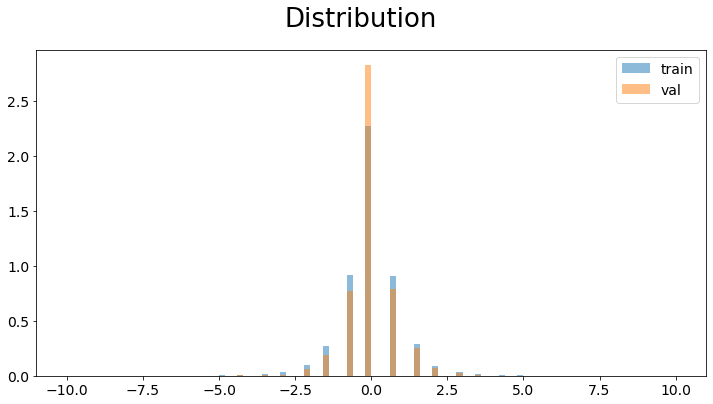

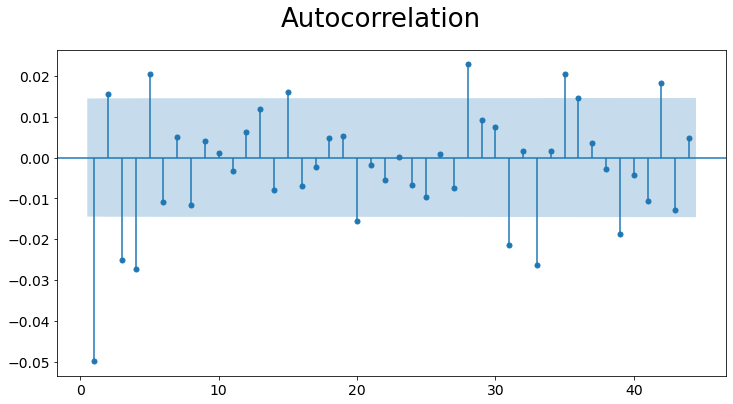

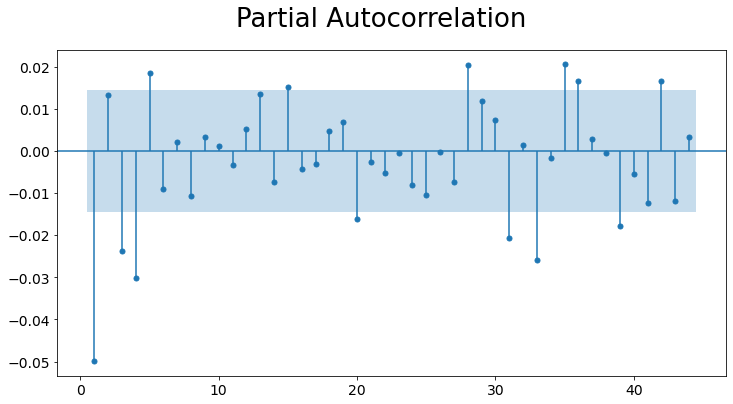

<IPython.core.display.Javascript object>

In [8]:
trans = IHSTransformer(train_intv.view(ts), verbose=True)
original_trans_ts = trans_ts = trans.transform(ts)

fig = plot_hist(
    train_intv.view(trans_ts), bins=100, range=(-10, 10), density=True, name="train"
)
display(
    plot_hist(
        val_intv.view(trans_ts),
        bins=100,
        range=(-10, 10),
        density=True,
        name="val",
        fig=fig,
        title="Distribution",
    )
)

alpha = 0.04
display(plot_acf(train_intv.view(trans_ts), alpha=alpha, zero=False))
display(plot_pacf(train_intv.view(trans_ts), alpha=alpha, zero=False))

In [9]:
trans_ts_acf, _ = acf(train_intv.view(trans_ts), nlags=100, alpha=alpha)
(trans_ts_acf_idx,) = np.where(np.abs(trans_ts_acf) >= 0.02)

trans_ts_pacf, _ = pacf(train_intv.view(trans_ts), nlags=100, alpha=alpha)
(trans_ts_pacf_idx,) = np.where(np.abs(trans_ts_pacf) >= 0.02)

print(f"acf: {trans_ts_acf_idx}")
print(f"pacf: {trans_ts_pacf_idx}")

acf: [ 0  1  3  4  5 28 31 33 35 69 82]
pacf: [ 0  1  3  4 28 31 33 35 82]


<IPython.core.display.Javascript object>

### Downsampling

In [10]:
val_results.scores_table()

Scoring                        RMSE       MAE      MASE     sMAPE
Model             Version                                        
Median of Medians (1,7)    0.000450  0.000385  7.139486  0.027817
ARIMA             (0,0,0)  0.000437  0.000372  6.766651  0.026922
                  (3,0,4)  0.000437  0.000372  6.781586  0.026901

<IPython.core.display.Javascript object>

MAE with smoothed: 0.0001262799538219819
MAE with interpolated: 0.00012890647053896638


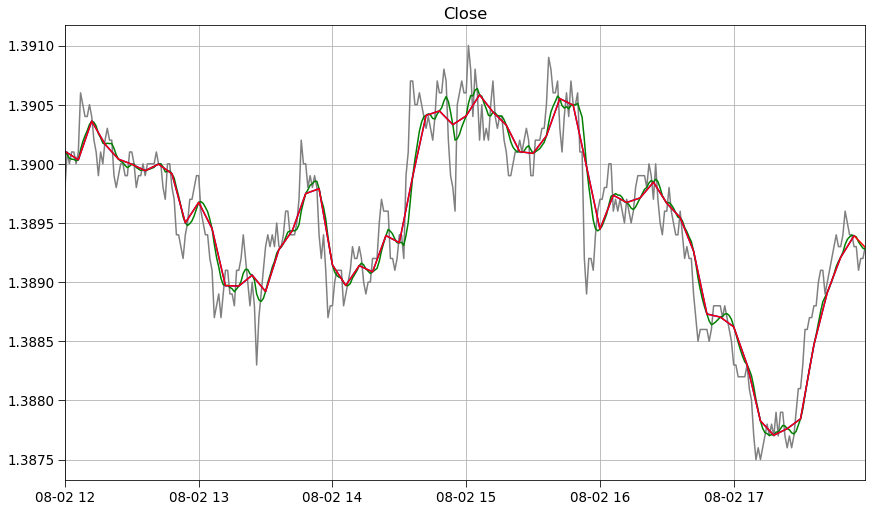

Order of differencing: 1
MLE of IHS lambda: 6487.5


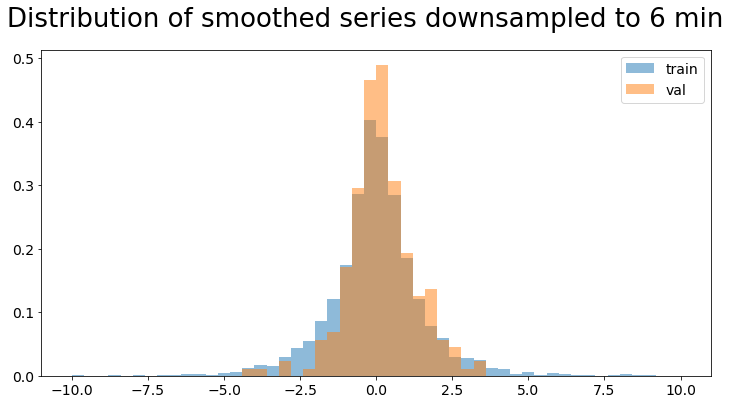

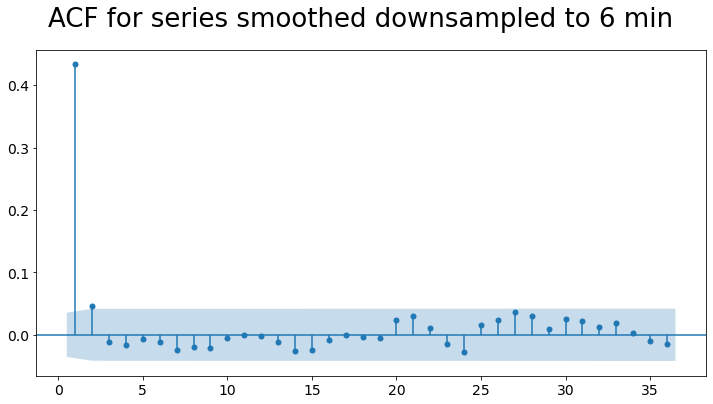

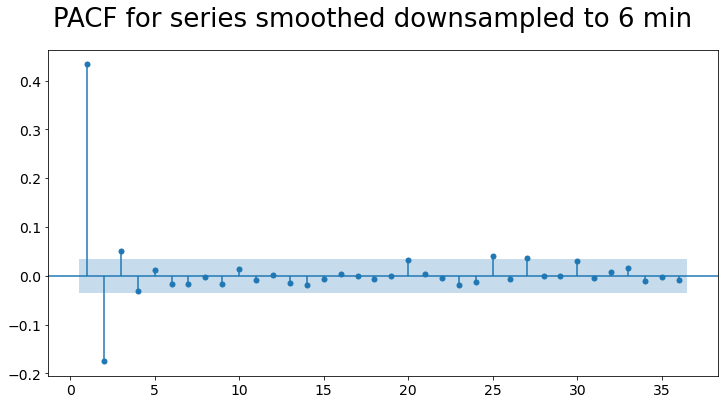

<IPython.core.display.Javascript object>

In [120]:
minutes = 6
std = 5
smoothed_ts = get_smoothed(ts, std=std, only_prevs=True)
downsampled_ts = get_downsampled(smoothed_ts, timedelta(minutes=minutes))
interpolated_ts = get_interpolated(downsampled_ts, train_intv)

mae = get_scoring("mae")
mae_smoothed = mae(train_intv.view(ts), train_intv.view(smoothed_ts))
mae_interpolated = mae(train_intv.view(ts), train_intv.view(interpolated_ts))
print(f"MAE with smoothed: {mae_smoothed}\nMAE with interpolated: {mae_interpolated}")

intv = tss.Interval(ts, datetime(2021, 8, 2, 12), datetime(2021, 8, 2, 18))
fig = plot_ts(intv.view(ts), color="grey")
plot_ts(intv.view(smoothed_ts), color="green", fig=fig)
plot_ts(intv.view(downsampled_ts), color="blue", fig=fig)
display(plot_ts(intv.view(interpolated_ts), color="red", fig=fig))

downsampled_trans = IHSTransformer(train_intv.view(downsampled_ts), verbose=True)
downsampled_trans_ts = trans.transform(downsampled_ts)

fig = plot_hist(
    train_intv.view(downsampled_trans_ts),
    bins=50,
    range=(-10, 10),
    density=True,
    name="train",
    title=f"Distribution of smoothed series downsampled to {minutes} min",
)
display(
    plot_hist(
        val_intv.view(downsampled_trans_ts),
        bins=50,
        range=(-10, 10),
        density=True,
        name="val",
        fig=fig,
    )
)

alpha = 0.04
display(
    plot_acf(
        train_intv.view(downsampled_trans_ts),
        alpha=alpha,
        zero=False,
        title=f"ACF for series smoothed downsampled to {minutes} min",
    )
)
display(
    plot_pacf(
        train_intv.view(downsampled_trans_ts),
        alpha=alpha,
        zero=False,
        title=f"PACF for series smoothed downsampled to {minutes} min",
    )
)

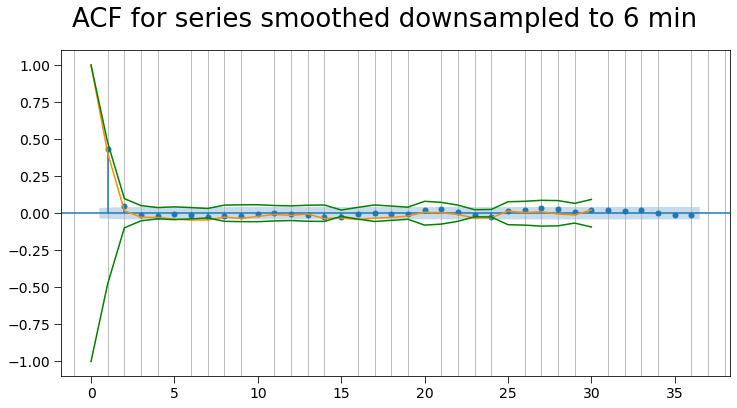

<IPython.core.display.Javascript object>

In [123]:
n = 30
min_pacf_values = np.full(n + 1, np.inf)
max_unc = np.zeros((n + 1, 2))
d = 3
for i in range(0, d + 1):
    nexts = -i * 24 * 60 // minutes
    prevs = -(d - i) * 24 * 60 // minutes
    pacf_values, unc = acf(
        train_intv.view(downsampled_trans_ts, prevs=prevs, nexts=nexts),
        alpha=alpha,
        nlags=n,
    )
    min_pacf_values = np.minimum(min_pacf_values, pacf_values)
    max_unc = np.maximum(max_unc, unc)
fig = plot_acf(
    train_intv.view(downsampled_trans_ts),
    alpha=alpha,
    zero=False,
    title=f"ACF for series smoothed downsampled to {minutes} min",
)
plot_ts(min_pacf_values, color="darkorange", fig=fig)
plot_ts(max_unc[:, 1], color="green", fig=fig)
plot_ts(-max_unc[:, 1], color="green", fig=fig)

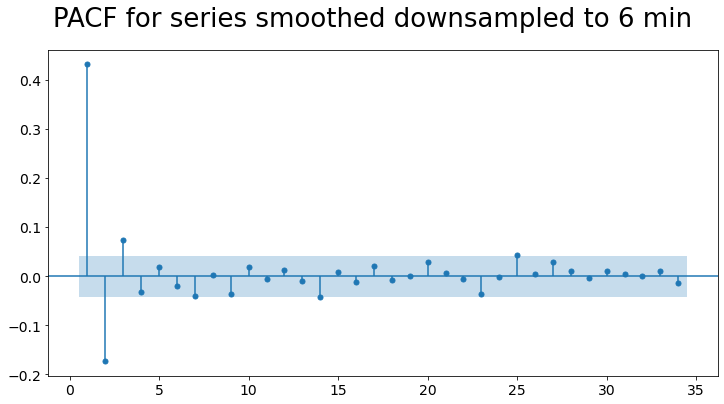

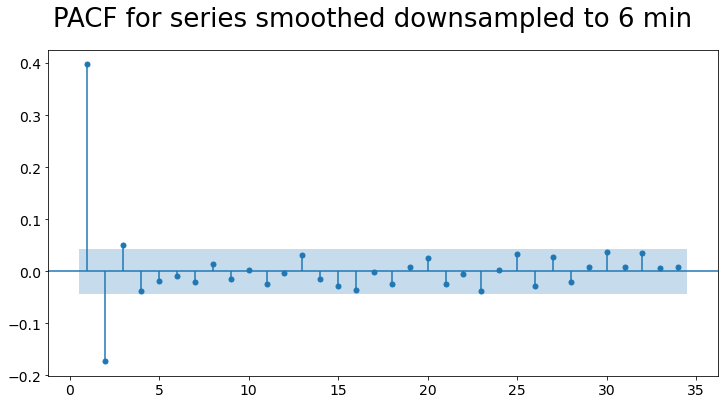

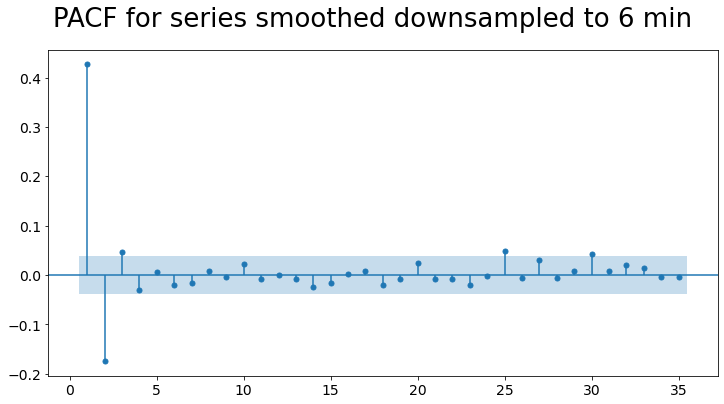

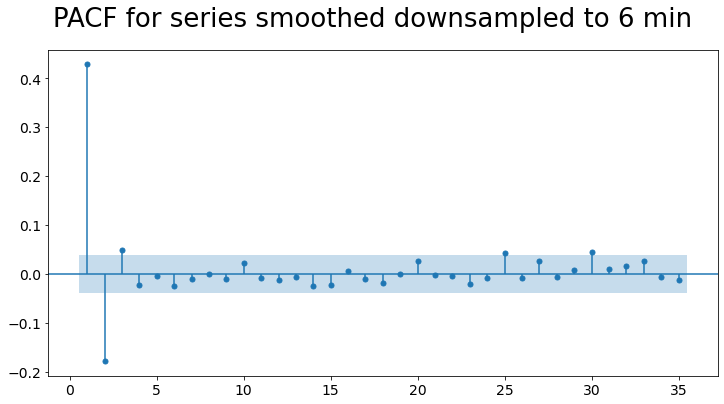

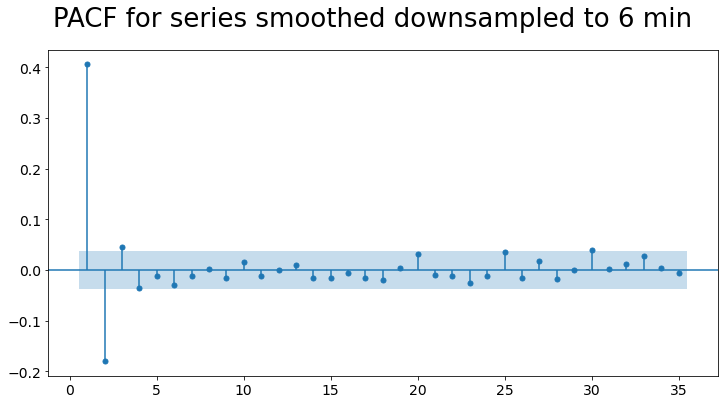

<IPython.core.display.Javascript object>

In [124]:
display(
    plot_pacf(
        train_intv.view(downsampled_trans_ts, nexts=-96 * 60 // minutes),
        alpha=alpha,
        zero=False,
        title=f"PACF for series smoothed downsampled to {minutes} min",
    )
)
display(
    plot_pacf(
        train_intv.view(
            downsampled_trans_ts, prevs=-72 * 60 // minutes, nexts=-36 * 60 // minutes
        ),
        alpha=alpha,
        zero=False,
        title=f"PACF for series smoothed downsampled to {minutes} min",
    )
)
display(
    plot_pacf(
        train_intv.view(
            downsampled_trans_ts, prevs=-24 * 60 // minutes, nexts=-24 * 60 // minutes
        ),
        alpha=alpha,
        zero=False,
        title=f"PACF for series smoothed downsampled to {minutes} min",
    )
)
display(
    plot_pacf(
        train_intv.view(
            downsampled_trans_ts, prevs=-36 * 60 // minutes, nexts=-12 * 60 // minutes
        ),
        alpha=alpha,
        zero=False,
        title=f"PACF for series smoothed downsampled to {minutes} min",
    )
)
display(
    plot_pacf(
        train_intv.view(downsampled_trans_ts, prevs=-48 * 60 // minutes),
        alpha=alpha,
        zero=False,
        title=f"PACF for series smoothed downsampled to {minutes} min",
    )
)

## Hyper Parameters Search

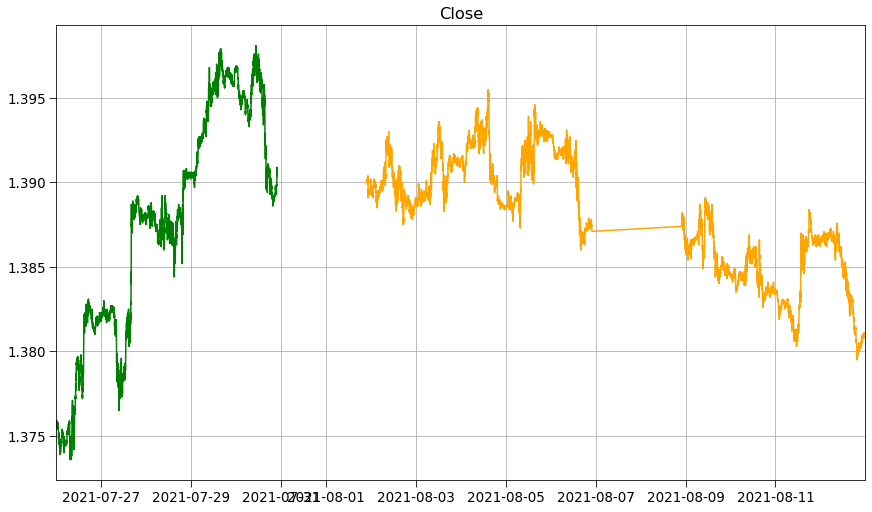

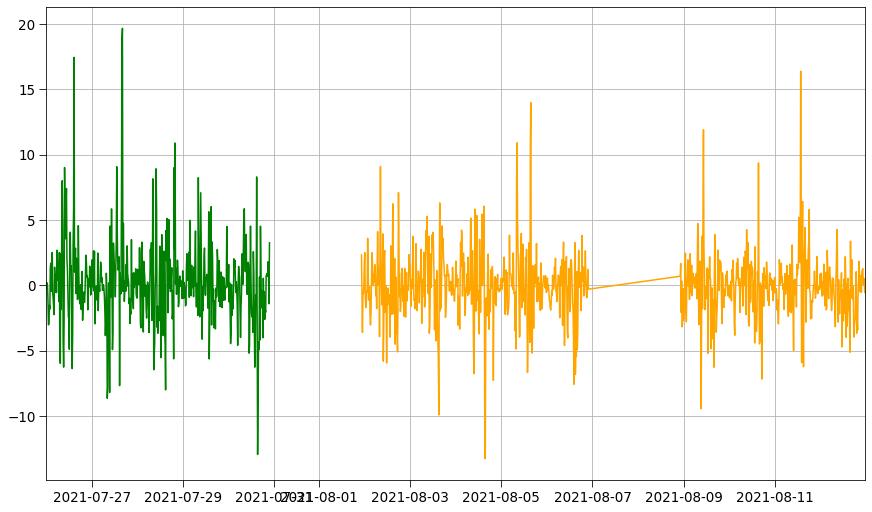

<IPython.core.display.Javascript object>

In [13]:
hyper_search_train_datetime = train_intv.begin
hyper_search_val_datetime = datetime(2021, 8, 1)
hyper_search_end_val_datetime = val_intv.begin
hyper_search_train_intv = tss.Interval(
    ts, hyper_search_train_datetime, hyper_search_val_datetime
)
hyper_search_val_intv = tss.Interval(
    ts, hyper_search_val_datetime, hyper_search_end_val_datetime
)
fig = plot_ts(hyper_search_train_intv.view(), color="green")
display(plot_ts(hyper_search_val_intv.view(), fig=fig, color="orange"))

fig = plot_ts(hyper_search_train_intv.view(downsampled_trans_ts), color="green")
display(
    plot_ts(hyper_search_val_intv.view(downsampled_trans_ts), color="orange", fig=fig)
)

In [58]:
def sarima_grid_search(scores=None):
    return grid_search_hyper_params(
        SarimaModel,
        grid,
        downsampled_trans_ts,
        hyper_search_train_intv,
        hyper_search_val_intv,
        model_params=model_params,
        score_params=score_params,
        fit_params=fit_params,
        best=None,
        scores=scores,
    )

<IPython.core.display.Javascript object>

In [125]:
score_params = dict(
    scorings=["mae"],
    original_ts=downsampled_ts,
    score_ts=downsampled_ts,
    n_steps=10,
    n_steps_jump=2,
    mute=True,
)

fit_params = dict(scoring="mse")

<IPython.core.display.Javascript object>

In [126]:
%%time
p_range = [0, 1, 2, 3, 4]
q_range = [0, 1, 2]
grid = make_grid(p=p_range, q=q_range)

model_params = dict(d=0, detrans=downsampled_trans)

sarima_grid_search_scores = sarima_grid_search()
    
pprint(sarima_grid_search_scores)

the best of all: 0.000421 (p=0, q=1)                                                                          


[(0.00042089440012947366, {'p': 0, 'q': 1}),
 (0.0004211808230515223, {'p': 2, 'q': 0}),
 (0.0004227383220277921, {'p': 0, 'q': 2}),
 (0.00042295047537783465, {'p': 4, 'q': 0}),
 (0.00042328725426216205, {'p': 4, 'q': 1}),
 (0.00042333089666470454, {'p': 1, 'q': 1}),
 (0.00042348107801720876, {'p': 4, 'q': 2}),
 (0.0004237481425846769, {'p': 3, 'q': 2}),
 (0.0004237488221607661, {'p': 3, 'q': 1}),
 (0.00042380372247212726, {'p': 0, 'q': 0}),
 (0.0004238839769988991, {'p': 2, 'q': 2}),
 (0.00042412714531422333, {'p': 2, 'q': 1}),
 (0.00042449301764649144, {'p': 1, 'q': 2}),
 (0.00042536939510654285, {'p': 3, 'q': 0}),
 (0.00043678212242352675, {'p': 1, 'q': 0})]
CPU times: user 2h 42min 42s, sys: 1h 30min 28s, total: 4h 13min 11s
Wall time: 1h 26min 43s


<IPython.core.display.Javascript object>

In [127]:
%%time
model = SarimaModel(p=0, d=0, q=1, detrans=downsampled_trans)
model.fit(downsampled_trans_ts, train_intv)
val_mean_scores, val_all_scores, val_preds = average_scores(
    model,
    downsampled_trans_ts,
    val_intv,
    scorings=scorings,
    original_ts=downsampled_ts,
    score_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores)

126/126 – RMSE: 0.00045, MAE: 0.00039, MASE: 7.79717, sMAPE: 0.02848, elapsed time: 29.1s (last: 0.5s)      
{'MAE': 0.00039370133734890287,
 'MASE': 7.7971742567874305,
 'RMSE': 0.0004512124104876395,
 'sMAPE': 0.028477509829415645}
CPU times: user 45.1 s, sys: 13.3 s, total: 58.3 s
Wall time: 29.4 s


<IPython.core.display.Javascript object>

In [48]:
val_results.scores_table()

Scoring                        RMSE       MAE      MASE     sMAPE
Model             Version                                        
Median of Medians (1,7)    0.000450  0.000385  7.139486  0.027817
ARIMA             (0,0,0)  0.000437  0.000372  6.766651  0.026922
                  (3,0,4)  0.000437  0.000372  6.781586  0.026901

<IPython.core.display.Javascript object>

## Training and Validation

In [50]:
%%time
model = SarimaModel(p=0, d=0, q=0, detrans=downsampled_trans)
model.fit(trans_ts, train_intv)
val_mean_scores, val_all_scores, val_preds = average_scores(
    model,
    downsampled_trans_ts,
    val_intv,
    scorings=scorings,
    original_ts=downsampled_ts,
    score_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores)

model_name = "ARIMA on downsampled"
model_version = "(0,0,0)"
val_results.set_model(model_name, model_version)
val_results.add_model_scores(val_mean_scores)
val_results.add_model_preds(val_preds)

126/126 – RMSE: 0.00055, MAE: 0.00050, MASE: 10.44075, sMAPE: 0.03613, elapsed time: 13.6s (last: 0.0s)      
{'MAE': 0.0004993990862325559,
 'MASE': 10.440754027599086,
 'RMSE': 0.000552766374994991,
 'sMAPE': 0.036128807004207425}
CPU times: user 13.7 s, sys: 81.4 ms, total: 13.8 s
Wall time: 14.1 s


<IPython.core.display.Javascript object>

In [97]:
%%time
model2 = SarimaModel(p=3, d=0, q=4)
model2.fit(trans_ts, train_intv)
val_mean_scores2, val_all_scores2, val_preds2 = average_scores(
    model2,
    trans_ts,
    val_intv,
    scorings=scorings,
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores2)

model_name2 = "ARIMA"
model_version2 = "(3,0,4)"
val_results.set_model(model_name2, model_version2)
val_results.add_model_scores(val_mean_scores2)
val_results.add_model_preds(val_preds2)

0/3 – RMSE: 0.00000, MAE: 0.00000, MASE: 0.00000, sMAPE: 0.00000,       

ValueError: Found input variables with inconsistent numbers of samples: [900, 60]

<IPython.core.display.Javascript object>

### Distributions of Validation Errors

In [110]:
scoring_name = "MAE"
fig = plot_hist_model_scores(
    val_all_scores,
    scoring_name,
    data_name=data_name,
    model_name=model_name,
    model_version=model_version,
    in_label=True,
    engine="plotly",
)
# display(
#     plot_hist_model_scores(
#         data_name,
#         val_all_scores2,
#         scoring_name,
#         model_name=model_name2,
#         model_version=model_version2,
#         in_label=True,
#         fig=fig,
#     )
# )
display(fig)

<IPython.core.display.Javascript object>

### Visualization of Validation Predictions

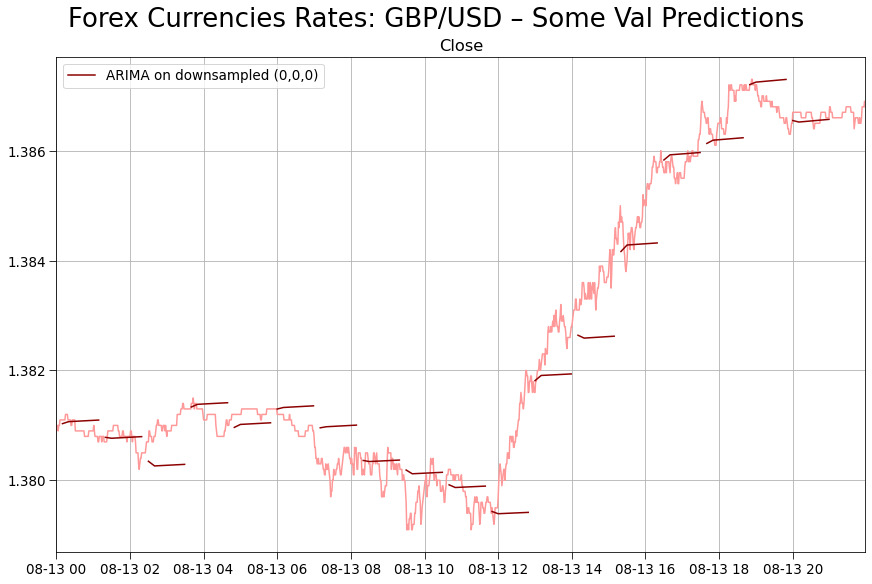

<IPython.core.display.Javascript object>

In [111]:
fig_time_delta = timedelta(minutes=10)
fig = plot_ground_truth(val_intv, mode="val", data_type=data_type, data_name=data_name)
fig = plot_model_test_prediction(
    val_intv,
    fig_time_delta,
    val_preds,
    model_name=model_name,
    model_version=model_version,
    fig=fig,
)
# display(
#     plot_model_test_prediction(
#         val_intv,
#         fig_time_delta,
#         val_preds2,
#         model_name=model_name2,
#         model_version=model_version2,
#         color="blue",
#         fig=fig,
#     )
# )
display(fig)

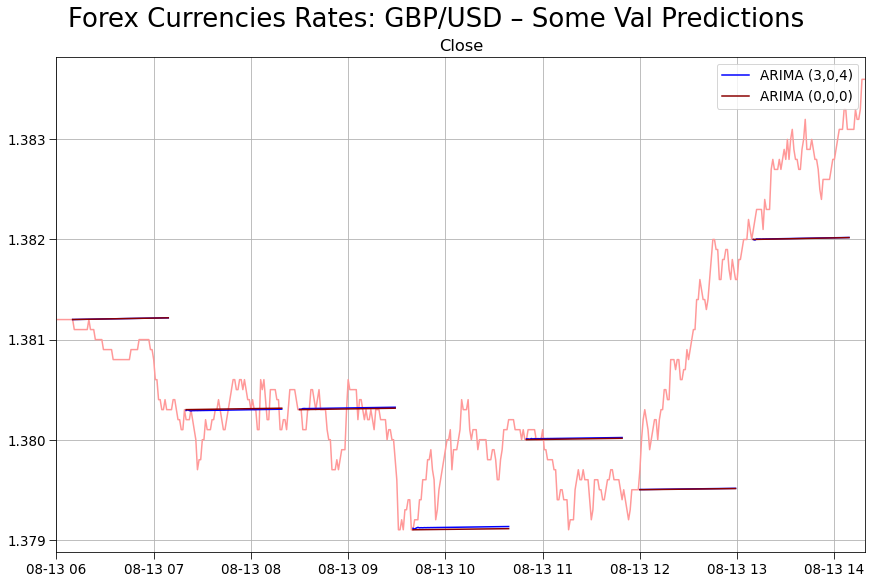

<IPython.core.display.Javascript object>

In [20]:
short_val_intv = tss.Interval(
    ts, datetime(2021, 8, 13, 6), datetime(2021, 8, 13, 14, 20)
)
fig_time_delta = timedelta(minutes=10)
fig = plot_ground_truth(
    short_val_intv, mode="val", data_type=data_type, data_name=data_name
)
fig = plot_model_test_prediction(
    short_val_intv,
    fig_time_delta,
    val_preds2,
    model_name=model_name2,
    model_version=model_version2,
    color="blue",
    fig=fig,
)
display(
    plot_model_test_prediction(
        short_val_intv,
        fig_time_delta,
        val_preds,
        model_name=model_name,
        model_version=model_version,
        fig=fig,
    )
)

## Test Predictions

In [24]:
%%time
model.update(trans_ts, val_intv)
test_mean_scores, test_all_scores, test_preds = average_scores(
    model,
    trans_ts,
    test_intv,
    scorings=scorings,
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(test_mean_scores)
test_results.set_model(model_name, model_version)
test_results.add_model_scores(test_all_scores, test_mean_scores)
test_results.add_model_preds(test_preds)

144/144 – RMSE: 0.00050, MAE: 0.00043, MASE: 6.66558, sMAPE: 0.03110, elapsed time: 5min 14s (last: 2.2s)      
{'MAE': 0.0004308404932227385,
 'MASE': 6.665584215869363,
 'RMSE': 0.0005010577911195152,
 'sMAPE': 0.031100765288064127}
CPU times: user 6min 4s, sys: 3min 20s, total: 9min 24s
Wall time: 5min 16s


<IPython.core.display.Javascript object>